In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.quantum_info import Operator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import *

In [2]:
qc = QuantumCircuit(1)

qc.rz(np.pi/8, 0)

print("Original circuit:")
print(qc.draw())
 
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
 
discretized = skd(qc)
 
print("Discretized circuit:")
print(discretized.draw())
 
print("Error:", np.linalg.norm(Operator(qc).data - Operator(discretized).data))

#discretized.draw("mpl")

Original circuit:
   ┌─────────┐
q: ┤ Rz(π/8) ├
   └─────────┘
Discretized circuit:
   ┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐»
q: ┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├»
   └───┘└───┘└─────┘└───┘└─────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└─────┘└───┘»
«   ┌─────┐┌───┐
«q: ┤ Tdg ├┤ H ├
«   └─────┘└───┘
Error: 0.07944281142466891


In [3]:
qc = QuantumCircuit(1)

qc.rz(-np.pi/8, 0)

print("Original circuit:")
print(qc.draw())
 
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
 
discretized1 = skd(qc)
 
print("Discretized circuit:")
print(discretized1.draw())
 
print("Error:", np.linalg.norm(Operator(qc).data - Operator(discretized1).data))

#discretized.draw("mpl")

Original circuit:
   ┌──────────┐
q: ┤ Rz(-π/8) ├
   └──────────┘
Discretized circuit:
   ┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌───┐»
q: ┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ T ├┤ H ├┤ T ├»
   └───┘└───┘└───┘└───┘└───┘└─────┘└───┘└─────┘└───┘└─────┘└───┘└───┘└───┘└───┘»
«   ┌───┐┌─────┐
«q: ┤ H ├┤ Tdg ├
«   └───┘└─────┘
Error: 0.07944281142466901


In [4]:
def root_T(qc: QuantumCircuit, pos):
    circ = QuantumCircuit(1)
    circ.rz(np.pi/8, 0)
    basis = ["t", "tdg", "z", "h"]
    approx = generate_basic_approximations(basis, depth=3)
    skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
    discretized = skd(circ)
    hmm = discretized.data
    for instruction in hmm:
        if instruction.name == "t":
            qc.t(pos)
        if instruction.name == "tdg":
            qc.tdg(pos)
        if instruction.name == "h":
            qc.h(pos)

def adj_root_T(qc: QuantumCircuit, pos):
    circ = QuantumCircuit(1)
    circ.rz(-np.pi/8, 0)
    basis = ["t", "tdg", "z", "h"]
    approx = generate_basic_approximations(basis, depth=3)
    skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
    discretized = skd(circ)
    hmm = discretized.data
    for instruction in hmm:
        if instruction.name == "t":
            qc.t(pos)
        if instruction.name == "tdg":
            qc.tdg(pos)
        if instruction.name == "h":
            qc.h(pos)

def CT(qc: QuantumCircuit):
    root_T(qc, 0)
    root_T(qc, 1)
    qc.cx(0,1)
    adj_root_T(qc,1)
    qc.cx(0,1)

In [5]:
qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)

CT(qc)
CT(qc)
CT(qc)
CT(qc)

qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

#qc.draw("mpl")

{'0': 232, '1': 9768}


{'1': 1464017, '0': 8535983}


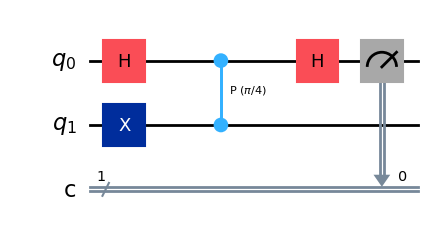

In [6]:
qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)

qc.cp(np.pi/4, 0, 1)

# qc.p(np.pi/8, 0)
# qc.p(np.pi/8, 1)
# qc.cx(0,1)
# qc.p(-np.pi/8,1)
# qc.cx(0,1)


# solovay(qc, discretized=discretized, pos=0)
# solovay(qc, discretized=discretized, pos=1)
# qc.cx(0,1)
# solovay(qc, discretized=discretized1, pos=1)
# qc.cx(0,1)



qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000000)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

{'1': 10000}


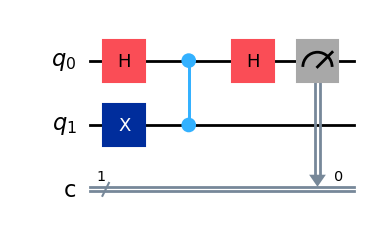

In [7]:
#iQPE first iteration

qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)

qc.cz(0,1)

qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

{'0': 10000}


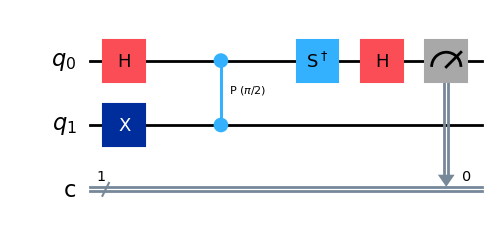

In [8]:
#iQPE second iteration

qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)

qc.cp(np.pi/2,0,1)

qc.sdg(0)

qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

{'0': 10000}


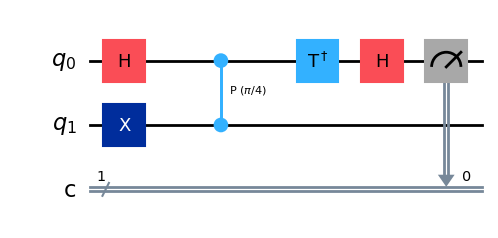

In [9]:
#iQPE third iteration

qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)


qc.cp(np.pi/4,0,1)

qc.tdg(0)

qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

{'1 00': 1000}


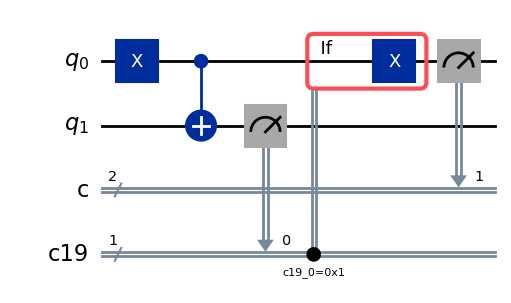

In [27]:
p = 0.0
p_error = pauli_error([["Z",p],["I",1-p]])
p_error_2 = pauli_error([["IX",p],["II",1-p]])

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(p_error_2, ["cx"])  # Apply to single-qubit gates

#iQPE third iteration

qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cbits)

matrix_h = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix_h)
matrix_cx = ([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
cx_ideal = UnitaryGate(matrix_cx) 

lel = ClassicalRegister(1)
qc.add_register(lel)
qc.x(0)
qc.cx(0,1)
#qc.append(cx_ideal,[1,0])
qc.measure(1,lel[0])
# qc.measure(1,1)

def test(qc: QuantumCircuit):
    with qc.if_test((lel[0],1)):
        qc.x(0)

test(qc)

qc.measure(0,1)

sim = AerSimulator()
    
job = sim.run(qc, shots=1000, noise_model=noise_model)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

{'001': 763, '000': 9237}


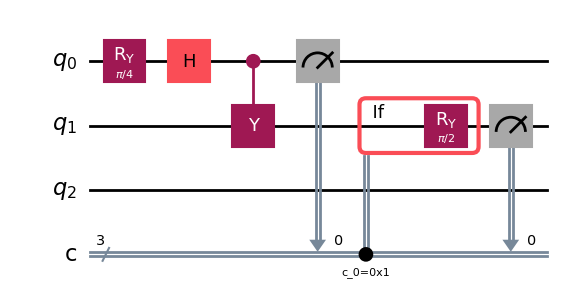

In [70]:
qr = QuantumRegister(3,"q")
cbits = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cbits)

qc.ry(np.pi/4,0)
qc.h(0)
#qc.x(1)

qc.cy(0,1)

qc.measure(0,0)

with qc.if_test((0,1)):
    qc.ry(np.pi/2,1)

qc.measure(1,0)

# qc.ry(-np.pi/4,1)

# qc.h(2)

# qc.ry(np.pi/4,1)
# qc.cz(1,2)
# qc.ry(-np.pi/4,1)

# qc.h(2)

# qc.measure(2,2)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

# yeah = list(counts.keys())

# print(yeah[0])

# yikes = [""]
# k = 0

# for i in yeah[0]:
#     if i == " ":
#         yikes.append("")
#         k += 1
#     yikes[k] += i

# print(yikes)

qc.draw("mpl")

{'0': 10000}


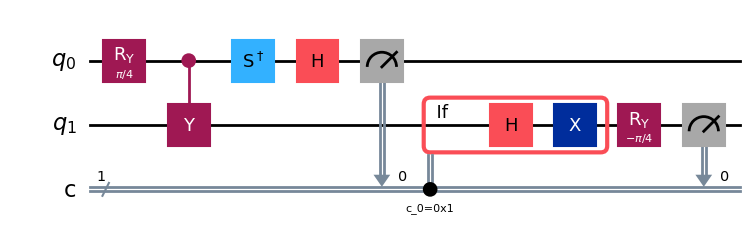

In [145]:
qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.ry(np.pi/4,0)

qc.cy(0,1)

qc.sdg(0)
qc.h(0)
qc.measure(0,0)

with qc.if_test((0,1)):
    qc.h(1), qc.x(1)
    #qc.x(1), qc.h(1)
    #qc.ry(np.pi/2,1)

qc.ry(-np.pi/4,1)
# qc.h(1)

qc.measure(1,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")